Steps for NLP Model Build:

A Capstone project applying NLP modeling to Amazon Question and Answer banks 

by Robert Spoonmore

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import nltk
#import pprint
#from gensim import corpora
import re
from gensim.models import doc2vec, Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

In [2]:
# Define path for Amazon data
path = r'/Users/robertspoonmore/Desktop/Capstone datasets/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [3]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [4]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")
food_df.head()

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [5]:
# Create food dataframe holding the product id, question, and associated answer
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


In [6]:
# in viewing the df, look for missing values
print('shape: ',food.shape)
food.isna().sum()

shape:  (19538, 3)


asin        0
question    0
answer      0
dtype: int64

In [7]:
food.dtypes

asin        object
question    object
answer      object
dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


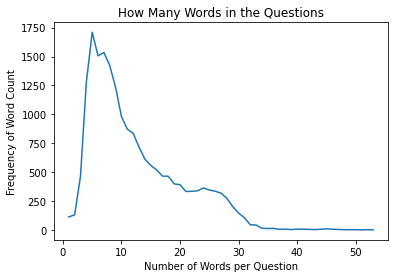

In [8]:
# Look at the word count of all the questions
food['words in question'] = food['question'].str.split().str.len()
word_count = food['words in question'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Question')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Questions')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


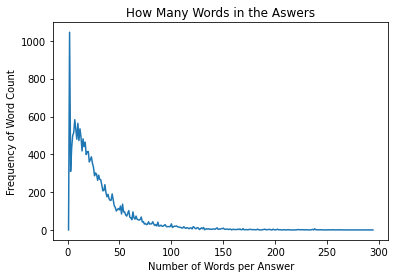

In [9]:
# Look at the word count of all the anwers
food['words in answer'] = food['answer'].str.split().str.len()
word_count = food['words in answer'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Answer')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Aswers')
plt.show()

In [10]:
# We must consider all answers regardless of size
# Look at the type of answers we see in the category
food['words in answer'].value_counts()
# We can see that there are 1045 answers that are only one word
one_word_answers = food[food['words in answer']==1]

# Create a series of data from the answer column
one_word_answers = one_word_answers['answer'].squeeze()
# lower case all letters
one_word_answers = one_word_answers.str.lower()
# remove periods at end of the answers - some yes show up as yes.
one_word_answers = one_word_answers.str.rstrip('.!? \n\t')
print('Count of all one word answers: ',len(one_word_answers))
print('\nTop frequency one word answers: \n'
      ,one_word_answers.value_counts().head(10))
# we can see a large volumne of yes,no answers and simple responses
# Look at unique responses that are website addresses
#web_links = one_word_answers[one_word_answers.str.contains('www')]
print('\nAnswers that are links ("www"): ',len(one_word_answers[one_word_answers.str.contains('www')]))

Count of all one word answers:  1045

Top frequency one word answers: 
 yes           422
no            217
plastic        22
glass          11
one             9
                9
nope            7
absolutely      7
usa             6
yep             6
Name: answer, dtype: int64

Answers that are links ("www"):  15


In [11]:
# remove rows for questions that have only 1, 2, or 3 words
food = food[food['words in question']>3]
print("shape :",food.shape)
print("min words per question: ",food['words in question'].min())
food.head()

shape : (18827, 5)
min words per question:  4


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [12]:
#df[df['column name'].isna()]
na = food_df[food_df['answerTime']=='NaT']
print(na.count())
# verify no blanks in data

questionType    0
asin            0
answerTime      0
unixTime        0
question        0
answer          0
answerType      0
dtype: int64


# Preparing the question text data

In [13]:
# Import necessary modules
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# select only questions and answers and group by product id (asin)
## Create product dataframe grouped by product bringing multiple questions and answers together
product_df = food[['asin','question','answer']]
product_df = product_df.groupby('asin').agg(lambda x: x.tolist())
#print("shape of product data",product_df.shape)
print("Number of product questions: ",len(product_df))
product_df.head()

Number of product questions:  3016


,question,answer
asin,,
9742356831,[What is the heat of this compared to the yell...,[I think that the yellow is the most mild. The...
B00004S1C5,[Why does this product come up first when doin...,[Also. I am looking for organic coloring....no...
B0000CD03D,[It says - Uncle Sam Cereal 12X 10 Oz Uncle Sa...,[No! It is false advertising. I got one box we...
B0000CD06J,"[Ingredience Barly ? etc., What are all the in...","[Roasted barley, rye, chicory, sugar beets., I..."
B0000CERE4,"[Is this just one bottle for $49.95?, Is there...","[I believe it is for 6. I love the stuff!, On ..."


# Bag of Words for Questions and Answers 

In [16]:
# Create bag of words Counter and look at most common words in the questions
# first import libraries for tokenization
from nltk.tokenize import word_tokenize
from collections import Counter

In [17]:
# method to tokenize anything sent to give back a list of words (bag of words)
# strip out non-alphanumeric words (remove punctuation), remove stop words
# return an overall list with each word separate

def find_words(source, stop_words_removed=False):
    list_of_words = []
    for row in source:
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words

        # Remove stopwords if requested
        if stop_words_removed:
            no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
            # save resultant words
            for word in no_stops:
                list_of_words.append(word)
        else:
            for word in lower_tokens:
                list_of_words.append(word)
    return list_of_words

In [18]:
# method to tokenize anything sent to give back a list of list of words as they appeared
# strip out non-alphanumeric words (remove punctuation), remove stop words
# return an overall list with phrase as separate list

def find_phrases(source):
    list_of_list_of_words = []
    for row in source:
        list_of_words = []
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words
        for word in lower_tokens:
            list_of_words.append(word)
        list_of_list_of_words.append(list_of_words)
        
    return list_of_list_of_words

In [19]:
# Find the most common words in the questions keeping the stopwords
question_phrases = find_phrases(food['question'])
print("Question phrases count: ",len(question_phrases),'\n')
print("Question phrases first 10: \n",question_phrases[:10])

Question phrases count:  18827 

Question phrases first 10: 
 [['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry'], ['is', 'there', 'msg', 'in', 'it'], ['what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this', 'product', 'thanks'], ['how', 'important', 'is', 'the', 'expiraci', 'oacute', 'n', 'date', 'on', 'this', 'curry', 'paste'], ['the', 'product', 'description', 'says', 'but', 'the', 'picture', 'shows', 'the', 'lb', 'oz', 'version', 'which', 'is', 'it', 'thanks'], ['why', 'is', 'the', 'photo', 'of', 'the', 'product', 'for', 'red', 'curry', 'and', 'they', 'are', 'selling', 'green', 'curry', 'which', 'will', 'i', 'get', 'if', 'i', 'order', 'this'], ['why', 'does', 'this', 'product', 'come', 'up', 'first', 'when', 'doing', 'a', 'search', 'for', 'organic', 'food', 'coloring', 'i', 'can', 'find', 'nothing', 'here', 'that', 'says', 'it', 'organic'], ['what', 'are', 'the', 'ingredients', 'in', 'the', 'super', 'red', 'food', 'coloring']

In [20]:
# Find the most common words in the answers keeping the stopwords
answer_phrases = find_phrases(food['answer'])
print("Answer phrases count: ",len(answer_phrases),'\n')
print("Answer phrases first 10: \n",answer_phrases[:10])

Answer phrases count:  18827 

Answer phrases first 10: 
 [['i', 'think', 'that', 'the', 'yellow', 'is', 'the', 'most', 'mild', 'the', 'green', 'has', 'a', 'much', 'deeper', 'flavor', 'profile', 'than', 'the', 'yellow', 'and', 'red', 'though'], ['no', 'msg', 'in', 'mae', 'ploy', 'curry', 'pastes'], ['the', 'ingredients', 'are', 'listed', 'in', 'the', 'description'], ['i', 'never', 'pay', 'attention', 'to', 'it', 'myself', 'the', 'ingredients', 'in', 'the', 'curry', 'paste', 'are', 'long', 'lasting', 'but', 'thats', 'up', 'to', 'you'], ['we', 'bought', 'the', 'for', 'just', 'under'], ['i', 'ordered', 'one', 'of', 'each', 'product', 'the', 'red', 'and', 'the', 'green', 'and', 'received', 'one', 'of', 'each', 'each', 'about', 'shipped', 'quickly', 'and', 'carefully', 'packaged', 'no', 'complaints', 'here', 'hope', 'that', 'helps'], ['also', 'i', 'am', 'looking', 'for', 'organic', 'coloring', 'red', 'dye', 'so', 'yes', 'this', 'makes', 'no', 'sense', 'for', 'being', 'organic'], ['water', '

In [21]:
# Find the most common words in the questions keeping the stopwords 
question_words_all = find_words(food['question'], False)
bow_questions_all = Counter(question_words_all)
print("Total word count of Questions: ",len(question_words_all))
print("The most common words found are: ")
print(bow_questions_all.most_common(25))

Total word count of Questions:  230334
The most common words found are: 
[('the', 11854), ('is', 9334), ('this', 7103), ('i', 5236), ('it', 5213), ('in', 4686), ('to', 4351), ('a', 3990), ('of', 3969), ('are', 3718), ('what', 3663), ('how', 3550), ('does', 3028), ('or', 2884), ('for', 2693), ('and', 2645), ('you', 2597), ('can', 2373), ('these', 2144), ('do', 2117), ('have', 1716), ('product', 1711), ('with', 1534), ('on', 1507), ('that', 1411)]


In [22]:
# Find the most common words in the answers keeping the stopwords
answer_words_all = find_words(food['answer'], False)
bow_answers_all = Counter(answer_words_all)
print("Total word count of Answers: ",len(answer_words_all))
print("The most common words found are: ")
print(bow_answers_all.most_common(25))

Total word count of Answers:  557840
The most common words found are: 
[('the', 24607), ('i', 18017), ('it', 16385), ('and', 12936), ('a', 12067), ('is', 11682), ('to', 10988), ('of', 8895), ('in', 8709), ('you', 7617), ('for', 6110), ('that', 5965), ('not', 5807), ('this', 5110), ('are', 5100), ('have', 5003), ('but', 4330), ('on', 4244), ('they', 4225), ('with', 3789), ('as', 3527), ('do', 3455), ('no', 3150), ('if', 2930), ('be', 2904)]


From the pretreatment of the questions and answers to build a bag of words, 
the following is true when stopwords are included and counted:

Words for questions: 230334

Words for answers:   557840

# Pre Condition text

In [23]:
# Combine all words from questions and answers for bag of words including stopwords for model
all_words = question_words_all + answer_words_all
print("\nAll words in Q and A total:\n",len(all_words),'\n',all_words[:25])


All words in Q and A total:
 788174 
 ['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry', 'is', 'there', 'msg', 'in', 'it', 'what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this']


## Build model for tokenization

In [24]:
# Train the Doc2Vec model
def train_model(word_list):
   for i, list_of_words in enumerate(word_list):
      yield TaggedDocument(list_of_words, [i])
train_data = list(train_model(all_words))

In [25]:
# Determine number of words in list to predict vector_size
size = len(set(all_words))
print("The vector_size should be: ",size)

The vector_size should be:  18632


In [26]:
################# This step takes over an hour - reload model if needed #################
# Initialize model
model = doc2vec.Doc2Vec(vector_size=18632, min_count=2, epochs=30)

# Build Vocabulary
model.build_vocab(train_data)

In [27]:
################# This step takes over an hour - reload model if needed #################
# Train the Model
import time
start_time = time.time()
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)
print("Time to train the model: ",time.time()-start_time,"seconds")

Time to train the model:  4455.347857952118


In [28]:
# Save model
start_time = time.time()
model.save('d2v_food.model')
print("Time to save the model: ",time.time()-start_time,"seconds")

Building a TF-IDF model using gensim model. 
The tf-idf model transforms vectors from the bag-of-words 
to a vectors where the frequency counts 
are weighted according to the rarity of each word in the corpus.

tfidf is a read-only object that can be used to convert a vector from a previous 
form (bag-of-words integer counts) to new form 